In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_curve, auc
from sklearn import svm
from sklearn.model_selection import PredefinedSplit, GridSearchCV
import warnings

In [2]:
#Reads in training dataset (80% of given observations)
df = pd.read_csv('train_X.csv')
numeric_columns = ['min', 'max', 'mean', 'sd', 'range',
       'sum','duplicates', 'mra_D1_min', 'mra_D1_max', 'mra_D1_mean', 'mra_D1_sd',
       'mra_D1_range', 'mra_D1_zero', 'mra_D2_min', 'mra_D2_max',
       'mra_D2_mean', 'mra_D2_sd', 'mra_D2_range', 'mra_D2_zero', 'mra_D3_min',
       'mra_D3_max', 'mra_D3_mean', 'mra_D3_sd', 'mra_D3_range', 'mra_D3_zero',
       'tri_min', 'tri_max', 'tri_mean', 'tri_sd', 'tri_range', 'var_sill',
       'var_range', 'var_kappa']
# df = pd.concat([df[['image_id', 'classification']], pd.DataFrame(StandardScaler().fit_transform(df[numeric_columns]), columns=numeric_columns)])
df = pd.concat([
    df[['image_id', 'classification']],
    pd.DataFrame(StandardScaler().fit_transform(df[numeric_columns]), columns=numeric_columns)
], axis=1)

#Reads in validation dataset (15% of given observations)
df_val = pd.read_csv('validate_X.csv')
df_val = pd.concat([
    df_val[['image_id', 'classification']],
    pd.DataFrame(StandardScaler().fit_transform(df_val[numeric_columns]), columns=numeric_columns)
], axis=1)

#Reads in test dataset (5% of given observations)
df_test = pd.read_csv('test_X.csv')
df_test = pd.concat([
    df_test[['image_id', 'classification']],
    pd.DataFrame(StandardScaler().fit_transform(df_test[numeric_columns]), columns=numeric_columns)
], axis=1)
df

,image_id,classification,min,max,mean,sd,range,sum,duplicates,mra_D1_min,...,mra_D3_range,mra_D3_zero,tri_min,tri_max,tri_mean,tri_sd,tri_range,var_sill,var_range,var_kappa
0,371,med,-0.197098,-0.230893,-0.210207,-0.214613,-0.206882,-0.210207,-1.198409,0.188957,...,-0.190071,-0.270253,-0.102101,-0.194732,-0.202568,-0.194749,-0.194738,-0.037780,-0.047950,-0.761404
1,693,low,3.324597,4.796719,4.874356,5.627270,5.579711,4.874356,0.419718,-4.168532,...,5.712779,-0.270253,3.748720,4.700971,5.774286,5.668977,4.700873,-0.004684,-0.048187,-0.155197
2,404,med,-0.198599,-0.239107,-0.214293,-0.226611,-0.223416,-0.214293,0.859210,0.209883,...,-0.202200,-0.270253,-0.180465,-0.208806,-0.223702,-0.209236,-0.208799,-0.037781,-0.048127,0.018005
3,679,low,-0.183238,-0.226061,-0.201066,-0.218583,-0.218760,-0.201066,-0.199565,0.208781,...,-0.201123,-0.270253,-0.155711,-0.207714,-0.220069,-0.207708,-0.207711,-0.037780,-0.047253,0.537611
4,967,low,-0.183756,-0.224326,-0.199780,-0.213349,-0.213875,-0.199780,-0.359380,0.205124,...,-0.197404,-0.270253,-0.150589,-0.203961,-0.214655,-0.203854,-0.203959,-0.037780,-0.047284,0.104606
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
779,451,med,-0.198599,-0.218270,-0.203776,-0.144040,-0.175138,-0.203776,-0.449276,0.172585,...,-0.180575,0.802840,-0.180465,-0.172668,-0.167452,-0.173258,-0.172656,-0.037731,-0.044290,0.018005
780,138,high,-0.198634,-0.239096,-0.214293,-0.226580,-0.223333,-0.214293,0.589522,0.209836,...,-0.202137,-0.270253,-0.180201,-0.208738,-0.223628,-0.209182,-0.208731,-0.037781,-0.048310,-0.241798
781,537,med,-0.185277,-0.228114,-0.203077,-0.222786,-0.220120,-0.203077,-1.058571,0.209486,...,-0.201364,-0.270253,-0.165218,-0.207933,-0.220597,-0.208010,-0.207929,-0.037781,-0.047428,-0.241798
782,697,low,3.320537,4.804306,4.876090,5.633489,5.604048,4.876090,0.469661,-4.071456,...,5.694148,-0.270253,2.210240,4.711989,5.762476,5.668296,4.712187,-0.004643,-0.048187,-0.155197


In [3]:
X_train = df.drop(['image_id','classification','min','max','range','sd','mean'],axis=1)
y_train = df['classification']
X_val = df_val.drop(['image_id','classification','min','max','range','sd','mean'],axis=1)
y_val = df_val['classification']
X_test = df_test.drop(['image_id','classification','min','max','range','sd','mean'],axis=1)
y_test = df_test['classification']


#clf = LogisticRegression(random_state=0,max_iter=1000).fit(X_train, y_train)
clf = RandomForestClassifier().fit(X_train, y_train)
# clf = KNeighborsClassifier(n_neighbors=3).fit(X_train, y_train)
#clf = svm.SVC(C = 1).fit(X_train, y_train)

print(f"Train Accuracy: {round(clf.score(X_train, y_train), 3)}")
print(f"Test Accuracy: {round(clf.score(X_val, y_val), 3)}")

print(confusion_matrix(y_val, clf.predict(X_val)))

print("\nFeature importances:")
zipped_lists = zip(clf.feature_importances_, X_train.columns)
sorted_pairs = sorted(zipped_lists, reverse=True)
for pair in sorted_pairs:
    print(f"{round(pair[0], 2)} {pair[1]}")

Train Accuracy: 1.0
Test Accuracy: 0.673
[[71  0  2]
 [ 9  9  8]
 [29  0 19]]

Feature importances:
0.19 var_range
0.13 sum
0.06 var_kappa
0.06 duplicates
0.04 mra_D1_sd
0.04 tri_mean
0.03 mra_D1_max
0.03 mra_D1_range
0.03 tri_min
0.03 tri_max
0.03 mra_D2_min
0.03 mra_D2_max
0.03 mra_D3_range
0.03 tri_range
0.03 mra_D3_max
0.03 mra_D2_range
0.02 mra_D2_sd
0.02 mra_D3_min
0.02 tri_sd
0.02 mra_D1_min
0.02 mra_D3_sd
0.01 var_sill
0.01 mra_D1_zero
0.01 mra_D3_zero
0.01 mra_D2_zero
0.01 mra_D1_mean
0.01 mra_D3_mean
0.01 mra_D2_mean


In [4]:
#Creates an index list to be used so that gridsearchcv differentiates between existing training and validation sets
split_index = [-1]*len(X_train) + [0]*len(X_val)
ps = PredefinedSplit(test_fold = split_index)
X = np.concatenate((X_train, X_val), axis=0)
y = np.concatenate((y_train, y_val), axis=0)



############################ Random Forest Hyperparameter Search ############################################
rf = RandomForestClassifier()
rf_params = {
 'max_depth': [10, 50, 100],
 'random_state':[0],
 'n_estimators': [200, 1000, 2000]
}

clf_rf = GridSearchCV(estimator = rf, cv=ps,scoring = "f1_weighted", param_grid=rf_params)
clf_rf.fit(X, y)
print("Best Random Forest Score:", clf_rf.best_score_)
print("Best Random Forest Params:", clf_rf.best_params_)

############################ Logistic Regression Hyperparamter Search #######################################
warnings.filterwarnings("ignore")
lr = LogisticRegression()
lr_params = {
    "C": [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 1e2, 1e3, 1e4],
    "random_state": [0],
    "max_iter": [1000]
}
clf_lr = GridSearchCV(estimator = lr, cv=ps,scoring = "f1_weighted", param_grid=lr_params)
clf_lr.fit(X, y)
print("Best Logistic Regression Score:", clf_lr.best_score_)
print("Best Logistic Regression Params:", clf_lr.best_params_)

############################ K Nearest Neighbors Hyperparamter Search #######################################
knn = KNeighborsClassifier()
knn_params = {
    "n_neighbors": [i for i in range(1,20,1)]
}
clf_knn = GridSearchCV(estimator = knn, cv=ps, scoring = "f1_weighted", param_grid=knn_params)
clf_knn.fit(X, y)
print("Best KNN Classifier Score:", clf_knn.best_score_)
print("Best KNN Classifier Params:", clf_knn.best_params_)

############################ Support Vector Machine Hyperparamter Search #######################################
svm_mod = svm.SVC()
svm_params = {
    "C": [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 1e2, 1e3, 1e4],
    "random_state": [0]
}
clf_svm = GridSearchCV(estimator = svm_mod, cv=ps,scoring = "f1_weighted", param_grid=svm_params)
clf_svm.fit(X, y)
print("Best SVM Score:", clf_svm.best_score_)
print("Best SVM Params:", clf_svm.best_params_)

Best Random Forest Score: 0.6194256546962847
Best Random Forest Params: {'max_depth': 10, 'n_estimators': 1000, 'random_state': 0}
Best Logistic Regression Score: 0.5849515481388006
Best Logistic Regression Params: {'C': 10000.0, 'max_iter': 1000, 'random_state': 0}
Best KNN Classifier Score: 0.788921921102478
Best KNN Classifier Params: {'n_neighbors': 11}
Best SVM Score: 0.5502411429275003
Best SVM Params: {'C': 100.0, 'random_state': 0}


In [5]:
#Uses test set to assess final test error of tuned model
print(f"RF Test Accuracy: {round(clf_rf.score(X_test, y_test), 3)}")
print(f"LR Test Accuracy: {round(clf_lr.score(X_test, y_test), 3)}")
print(f"KNN Test Accuracy: {round(clf_knn.score(X_test, y_test), 3)}")
print(f"SVM Test Accuracy: {round(clf_svm.score(X_test, y_test), 3)}")

RF Test Accuracy: 0.646
LR Test Accuracy: 0.244
KNN Test Accuracy: 0.72
SVM Test Accuracy: 0.471


In [6]:
print(confusion_matrix(y_test, clf_rf.predict(X_test)))
print(confusion_matrix(y_test, clf_lr.predict(X_test)))
print(confusion_matrix(y_test, clf_knn.predict(X_test)))
print(confusion_matrix(y_test, clf_svm.predict(X_test)))


[[24  0  2]
 [ 2  1  0]
 [11  1  8]]
[[ 4 22  0]
 [ 0  3  0]
 [ 3 14  3]]
[[17  2  7]
 [ 0  2  1]
 [ 3  1 16]]
[[19  5  2]
 [ 2  1  0]
 [ 8  9  3]]


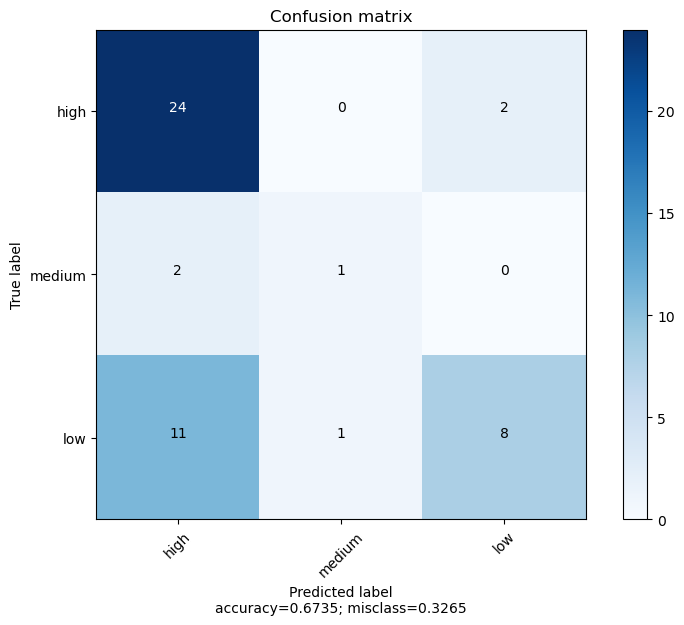

In [8]:
import numpy as np


def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / np.sum(cm).astype('float')
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()
    
plot_confusion_matrix(confusion_matrix(y_test, clf_rf.predict(X_test)),['high','medium','low'],normalize=False)